# Tree-Based Machine Learning Models

This notebook covers the ff:
- How decision trees work in machine learning
- Random forests in sklearn and H20
- Feature Importances from tree-based methods
- Boosted algorithms i.e. AdaBoost, XGBoost, LightGBM and CatBoost


## Decision Trees

Decision trees are simple algorithms, which split data based on specific values of the data.

In [159]:
import pandas as pd

df_path = "https://raw.githubusercontent.com/PacktPublishing/Practical-Data-Science-with-Python/main/15-Chapter-15/data/loan_data_sample.csv"

df = pd.read_csv(df_path)

df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Secondary / secondary special
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Higher education
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Secondary / secondary special
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Secondary / secondary special
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Secondary / secondary special


Since sklearn can only handle numeric data. Lets perform changes to the dataframe.

In [160]:
final_df = df.drop("SK_ID_CURR", axis = 1).copy()

final_df['NAME_CONTRACT_TYPE'] = final_df['NAME_CONTRACT_TYPE'].map(
                                            {'Cash loans': 0, 'Revolving loans': 1})
final_df['CODE_GENDER'] = final_df['CODE_GENDER'].map({'M': 0, 'F': 1})

final_df['FLAG_OWN_CAR'] = final_df['FLAG_OWN_CAR'].map({'N': 0, 'Y': 1})

final_df['FLAG_OWN_REALTY'] = final_df['FLAG_OWN_REALTY'].map(
                                        {'N': 0, 'Y': 1})

final_df['NAME_EDUCATION_TYPE'] = final_df['NAME_EDUCATION_TYPE'].map({'Lower secondary': 0,
                                                    'Secondary / secondary special': 0,
                                                    'Incomplete higher': 1,
                                                    'Higher education': 2,
                                                    'Academic degree': 2})
final_df.dropna(inplace=True)

In [161]:
# Verify the new df's features
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307217 entries, 0 to 307510
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   TARGET               307217 non-null  int64  
 1   NAME_CONTRACT_TYPE   307217 non-null  int64  
 2   CODE_GENDER          307217 non-null  float64
 3   FLAG_OWN_CAR         307217 non-null  int64  
 4   FLAG_OWN_REALTY      307217 non-null  int64  
 5   CNT_CHILDREN         307217 non-null  int64  
 6   AMT_INCOME_TOTAL     307217 non-null  float64
 7   AMT_CREDIT           307217 non-null  float64
 8   AMT_ANNUITY          307217 non-null  float64
 9   AMT_GOODS_PRICE      307217 non-null  float64
 10  NAME_EDUCATION_TYPE  307217 non-null  int64  
dtypes: float64(5), int64(6)
memory usage: 28.1 MB


We make a copy of the DataFrame so we still have the original version, and convert our string columns to numeric. Most of the columns are binary, so we can convert them to 0s and 1s. The education column has several values, and we turn them into an ordinal variable, which is a categorical category with ordering. 

We also need to drop missing values since sklearn cannot handle them (we could also impute missing values, of course). After this conversion, we can double-check the datatypes are correct with final_df.info().

> Decision trees work by splitting the data based on specific values from feature columns. For example, we might split our data into two groups based on AMT_INCOME_TOTAL, since above a value of around 200,000, the chances of payment
difficulty are slightly lower (in other words, the TARGET variable is more likely to be 0).

The machine learning aspect comes into play with decision trees from automating
splitting decisions. There are several different algorithms for creating decision trees, and some of the top algorithms are `C4.5, C5.0, and CART (classification and regression trees)`. 

The sklearn package uses a version of CART. With CART, we split the data into binary splits (as shown in Figure 15.1) and do so in a greedy manner.
For example, we try splitting the data on all features and all values of the features, and then find which one splits the data best. 

For classification, we measure the best split by the "purity" of the nodes, meaning the split that breaks up the data into unique classes best is used. We can measure this using the Gini criteria or entropy (entropy is also called "information gain"). Both these criteria have a minimum of 0 when the classes in the leaf nodes are pure, and have a maximum value when classes are evenly distributed. For regression, we can use measures such as **meansquare error (MSE), mean-absolute error (MAE), or others**.

In [133]:
# Before fitting models to the data, lets break it up into test and training sets

from sklearn.model_selection import train_test_split


features = final_df.drop("TARGET", axis = 1)

targets = final_df['TARGET']

x_train, x_test, y_train, y_test = train_test_split(features,
                                                    targets,
                                                    stratify = targets,
                                                    random_state = 42)
                                                   

In [134]:
from sklearn.tree import DecisionTreeClassifier

# Now lets fit a decision tree to our data

dt_class = DecisionTreeClassifier()

dt_class.fit(x_train, y_train)

print(f"Train Accuracy: {dt_class.score(x_train, y_train)}")
print(f"Test Accuracy: {dt_class.score(x_test, y_test)}")

Train Accuracy: 0.9991095280498664
Test Accuracy: 0.832


That looks like severe overfitting – the train score is almost 100% accuracy while
the test score is much lower. The reason for this is our decision trees are allowed to
grow to unlimited depths (or heights, if you want to think of it that way). The tree
continues to split the data until each leaf is very pure. 

While this works great for the training data and we can almost always get near 100% accuracy on the training set this way, it will almost always perform poorly on the test set. We can see how
many splits our decision tree has with dt.get_depth(), which turns out to be 50. This
means we have 50 splits and 50 layers of nodes after the root node, which is quite a
lot. The depth of the tree can be restricted with the max_depth hyperparameter, which
we set to 2 here:

In [135]:
small_dt_class = DecisionTreeClassifier(max_depth = 2, max_features = None)

small_dt_class.fit(x_train, y_train)

print(f"Train Accuracy: {small_dt_class.score(x_train, y_train)}")
print(f"Test Accuracy: {small_dt_class.score(x_test, y_test)}")

Train Accuracy: 0.9154051647373108
Test Accuracy: 0.9146666666666666


We also set the max_features hyperparameter, which controls how many features
are tried at each split. A random subset of features is used at each split, which is the
square root of the number of features by default. `Setting max_features=None` uses all
features at every split. There are several other hyperparameters we can set as well:
`criterion ('gini' or 'entropy')` and many others that control how many samples
can be in nodes or are required to split a node (such as min_samples_leaf). With
classification, we can also set class_weight to control the weights for each class in the
Gini criterion or entropy calculations.


Our accuracy on the train and test sets now are both around 93.6%, which is about
the same as the no information rate, meaning our model isn't doing better than
random chance. This doesn't mean it's completely useless – we might be able to
predict certain samples better than random chance and can understand relationships
of features to the target from the model. To understand this better, we can plot the
tree with an sklearn function:

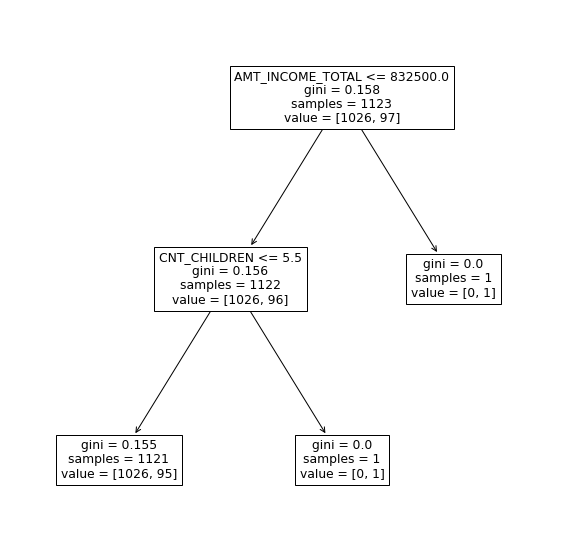

In [136]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


f = plt.figure(figsize = (10, 10))
_ = plot_tree(small_dt_class, feature_names = features.columns)



Decision trees are easy to explain because we can plot them and see the rules for
making splits. However, they are limited in performance (accuracy for classification)
due to their simplicity. One method that improves performance is random forests.

## Random Forests

Random forests build on decision trees. Instead of using a single tree, a forest
uses a collection of them (as you may have guessed from the name). Each tree is
built with a sample of the data which we get from bootstrapping, or sampling
with replacement. We also randomly subset the features at each split, as we saw is
possible with max_features for the sklearn decision trees. Random forests can also
be parallelized across processors or computers since we can build each decision
tree separately because they are independent of one another. This ML algorithm is
called an ensemble method since it uses a collection of models.



The combination of bootstrapping and combining several models in an ensemble is called bagging (a
portmanteau of bootstrapping and aggregating). There are several implementations
of random forests in Python, R, other programming languages, and data science
GUIs. Two easy ways to use them in Python are with sklearn and the H2O packages.

### Random Forests with SKLEARN



In [137]:

from sklearn.ensemble import RandomForestClassifier


rfc = RandomForestClassifier(max_depth = 10, n_jobs = -1, random_state = 42)

rfc.fit(x_train, y_train)

print(f"Train Accuracy: {rfc.score(x_train, y_train)}")
print(f"Test Accuracy: {rfc.score(x_test, y_test)}")

Train Accuracy: 0.9341050756901158
Test Accuracy: 0.9146666666666666


Here, we set a few other parameters for the classifier class: n_jobs=-1, which uses all
available CPU cores in parallel, and the random_state argument so that results are
reproducible. The scores here are about the same as the no information rate – 93.1%
accuracy.

We can tune the hyperparameters to improve our model. We can tune:
- The number of trees
- The depth of trees
- Max_Features for each split

We are searching some of the typical ranges for the three hyperparameters
mentioned above, and also fixing the random_state and n_jobs arguments. The
training data was sampled down to only 1,000 datapoints because this takes a while
to run, since we are fitting 135 models with the grid search (using the default of 5
CV splits with 3 unique values of 3 hyperparameters, or 5*3*3*3=135). After the grid
search completes, our best hyperparameters and score are the following

In [138]:
from sklearn.model_selection import GridSearchCV


x_tr_sample = x_train.sample(1000)

y_tr_sample = y_train.loc[x_tr_sample.index]


params = {'n_estimators': [100, 300, 500],
            'max_depth': [10, 15, 20],
            'max_features': [3, 6, 9],
            'random_state': [42],
            'n_jobs': [-1]}


gs = GridSearchCV(estimator = rfc, param_grid = params, n_jobs = -1)

gs.fit(x_tr_sample, y_tr_sample)

print(gs.best_estimator_)
print(gs.best_score_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
0.9110000000000001


We can see we're still not outperforming the no information rate, although we did
settle on a different value for the maximum number of features.

The training and hyperparameter search can take a long time with the full dataset or
another even bigger dataset, and we have a few options for dealing with it:

- Scale down the data with sampling
- Wait for the job to complete (although this could take hours or even days)
- Scale up to a more powerful computer (for example, using cloud resources)
- Scale up to a cluster using packages such as Dask
- Use another package or software that can scale using computing clusters

### Random Forest with H20


H2O is another ML package in Python besides sklearn. It has a few ML algorithms
and some nice advantages over sklearn. For random forests (and other tree-based
methods), it allows us to use missing values and categorical features, unlike sklearn.
H2O can also scale up on a cluster for big data. The H2O.ai company also offers
other products, such as their driverless AI, which is a data science and machine
learning GUI that offers lots of automation.

In [10]:
import h2o

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 18.0.1.1+2-6, mixed mode, sharing)
  Starting server from c:\Users\INNO\Documents\Python Development\Practical Data Science\final_env\final_env\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\INNO\AppData\Local\Temp\tmpkjnzxjv3
  JVM stdout: C:\Users\INNO\AppData\Local\Temp\tmpkjnzxjv3\h2o_INNO_started_from_python.out
  JVM stderr: C:\Users\INNO\AppData\Local\Temp\tmpkjnzxjv3\h2o_INNO_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.1
H2O_cluster_version_age:,1 month and 7 days
H2O_cluster_name:,H2O_from_python_INNO_aryamo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.953 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [11]:
hf = h2o.H2OFrame(df)

hf["TARGET"] = hf["TARGET"].asfactor()

train, valid = hf.split_frame(ratios=[.8], seed = 42)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


First, we simply use the h2o.H2OFrame function to convert our pandas DataFrame
to an H2OFrame. Then we set the target column as a "factor" datatype, meaning it
is a categorical variable. This is necessary so that the random forest will perform
categorization and not regression. We could also convert other non-string columns
that should be categorical to factors to be more thorough. Lastly, we break up our
data into training and validation sets, with 80% of the data going to training. Now
we can fit our model to the data and evaluate performance:

In [12]:
from h2o.estimators import H2ORandomForestEstimator


drf = H2ORandomForestEstimator(ntrees = 100, max_depth = 10, mtries = 3)

feature_columns = hf.columns

feature_columns.remove("TARGET")

target_column = "TARGET"

drf.train(x=feature_columns,
            y=target_column,
            training_frame=train,
            validation_frame=valid)
drf

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1653093399467_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,100.0,100.0,98460.0,10.0,10.0,10.0,48.0,100.0,73.38




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.06572158665417781
RMSE: 0.2563622176807218
LogLoss: 0.2623794357429694
Mean Per-Class Error: 0.3885067845138802
AUC: 0.628973193908461
AUCPR: 0.18402234344105498
Gini: 0.2579463878169219

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1487879599294355: 


,,0,1,Error,Rate
0,0,973.0,135.0,0.1218,(135.0/1108.0)
1,1,57.0,30.0,0.6552,(57.0/87.0)
2,Total,1030.0,165.0,0.1607,(192.0/1195.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.148788,0.238095,117.0
1,max f2,0.091521,0.319293,202.0
2,max f0point5,0.305326,0.294118,23.0
3,max accuracy,0.546875,0.929707,2.0
4,max precision,0.760347,1.000000,0.0
5,max recall,0.001210,1.000000,397.0
6,max specificity,0.760347,1.000000,0.0
7,max absolute_mcc,0.305326,0.206592,23.0
8,max min_per_class_accuracy,0.073032,0.595668,235.0
9,max mean_per_class_accuracy,0.136173,0.618356,130.0



Gains/Lift Table: Avg response rate:  7.28 %, avg score:  7.98 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010042,0.380633,5.723180,5.723180,0.416667,0.468729,0.416667,0.468729,0.057471,0.057471,472.318008,472.318008,0.051154
1,2,0.020084,0.305250,5.723180,5.723180,0.416667,0.332958,0.416667,0.400844,0.057471,0.114943,472.318008,472.318008,0.102307
2,3,0.030126,0.268633,1.144636,4.196999,0.083333,0.287123,0.305556,0.362937,0.011494,0.126437,14.463602,319.699872,0.103874
3,4,0.040167,0.243092,0.000000,3.147749,0.000000,0.252241,0.229167,0.335263,0.000000,0.126437,-100.000000,214.774904,0.093043
4,5,0.050209,0.222838,3.433908,3.204981,0.250000,0.235239,0.233333,0.315258,0.034483,0.160920,243.390805,220.498084,0.119403
5,6,0.100418,0.171724,1.144636,2.174808,0.083333,0.193983,0.158333,0.254620,0.057471,0.218391,14.463602,117.480843,0.127236
6,7,0.150628,0.140549,2.518199,2.289272,0.183333,0.156625,0.166667,0.221955,0.126437,0.344828,151.819923,128.927203,0.209449
7,8,0.200000,0.122899,0.931229,1.954023,0.067797,0.131879,0.142259,0.199719,0.045977,0.390805,-6.877070,95.402299,0.205787
8,9,0.300418,0.096420,1.144636,1.683476,0.083333,0.109065,0.122563,0.169417,0.114943,0.505747,14.463602,68.347581,0.221451
9,10,0.400000,0.074970,0.807978,1.465517,0.058824,0.085198,0.106695,0.148450,0.080460,0.586207,-19.202164,46.551724,0.200828




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.08937720731268622
RMSE: 0.29896021024993646
LogLoss: 0.3247372532149751
Mean Per-Class Error: 0.41333333333333333
AUC: 0.6216969696969697
AUCPR: 0.13274419818173797
Gini: 0.2433939393939395

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11625296175479893: 


,,0,1,Error,Rate
0,0,231.0,44.0,0.16,(44.0/275.0)
1,1,20.0,10.0,0.6667,(20.0/30.0)
2,Total,251.0,54.0,0.2098,(64.0/305.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.116253,0.238095,53.0
1,max f2,0.031641,0.397727,231.0
2,max f0point5,0.116253,0.203252,53.0
3,max accuracy,0.348601,0.898361,0.0
4,max precision,0.116253,0.185185,53.0
5,max recall,0.011668,1.000000,280.0
6,max specificity,0.348601,0.996364,0.0
7,max absolute_mcc,0.025834,0.135755,244.0
8,max min_per_class_accuracy,0.068463,0.566667,122.0
9,max mean_per_class_accuracy,0.048440,0.599697,178.0



Gains/Lift Table: Avg response rate:  9.84 %, avg score:  7.31 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.013115,0.276121,0.000000,0.000000,0.000000,0.309569,0.000000,0.309569,0.000000,0.000000,-100.000000,-100.000000,-0.014545
1,2,0.022951,0.246785,3.388889,1.452381,0.333333,0.252915,0.142857,0.285289,0.033333,0.033333,238.888889,45.238095,0.011515
2,3,0.032787,0.239543,0.000000,1.016667,0.000000,0.241670,0.100000,0.272203,0.000000,0.033333,-100.000000,1.666667,0.000606
3,4,0.042623,0.219391,0.000000,0.782051,0.000000,0.225826,0.076923,0.261501,0.000000,0.033333,-100.000000,-21.794872,-0.010303
4,5,0.052459,0.201147,3.388889,1.270833,0.333333,0.211545,0.125000,0.252134,0.033333,0.066667,238.888889,27.083333,0.015758
5,6,0.101639,0.151158,2.033333,1.639785,0.200000,0.170210,0.161290,0.212494,0.100000,0.166667,103.333333,63.978495,0.072121
6,7,0.150820,0.129422,1.355556,1.547101,0.133333,0.140410,0.152174,0.188988,0.066667,0.233333,35.555556,54.710145,0.091515
7,8,0.200000,0.105421,2.033333,1.666667,0.200000,0.116746,0.163934,0.171224,0.100000,0.333333,103.333333,66.666667,0.147879
8,9,0.301639,0.086710,0.655914,1.326087,0.064516,0.095426,0.130435,0.145683,0.066667,0.400000,-34.408602,32.608696,0.109091
9,10,0.400000,0.069406,1.355556,1.333333,0.133333,0.077323,0.131148,0.128873,0.133333,0.533333,35.555556,33.333333,0.147879




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-21 00:36:44,0.100 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-05-21 00:36:45,0.490 sec,1.0,0.330199,2.677670,0.606980,0.105789,0.000000,0.188372,0.371217,4.038783,0.507091,0.100345,0.000000,0.901639
2,,2022-05-21 00:36:45,0.566 sec,2.0,0.349798,3.316352,0.572616,0.094259,0.807978,0.263848,0.338889,2.420950,0.564970,0.121360,1.452381,0.288525
3,,2022-05-21 00:36:45,0.651 sec,3.0,0.332029,2.504306,0.622149,0.104908,0.832463,0.295174,0.329195,1.698207,0.586606,0.120920,0.000000,0.377049
4,,2022-05-21 00:36:45,0.691 sec,4.0,0.312433,1.958585,0.612495,0.108770,2.197701,0.321608,0.319012,1.286316,0.574364,0.119849,0.000000,0.475410
5,,2022-05-21 00:36:45,0.742 sec,5.0,0.306573,1.833051,0.601577,0.112069,2.616311,0.358543,0.315375,1.075125,0.592606,0.121076,0.000000,0.504918
6,,2022-05-21 00:36:45,0.794 sec,6.0,0.294238,1.478228,0.592657,0.123309,4.578544,0.299369,0.312037,0.963506,0.598667,0.121907,0.000000,0.360656
7,,2022-05-21 00:36:45,0.832 sec,7.0,0.285802,1.298071,0.605329,0.133336,6.867816,0.285589,0.307491,0.852483,0.624182,0.136933,0.000000,0.209836
8,,2022-05-21 00:36:45,0.866 sec,8.0,0.283880,1.257848,0.597720,0.122439,5.723180,0.176930,0.306793,0.846533,0.622848,0.132700,0.000000,0.409836
9,,2022-05-21 00:36:45,0.902 sec,9.0,0.284506,1.197090,0.599531,0.115294,3.433908,0.169666,0.306215,0.746624,0.603576,0.123103,0.000000,0.462295



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,SK_ID_CURR,568.539612,1.000000,0.182759
1,AMT_CREDIT,502.312469,0.883514,0.161470
2,AMT_ANNUITY,500.242035,0.879872,0.160804
3,AMT_INCOME_TOTAL,450.123322,0.791718,0.144693
4,AMT_GOODS_PRICE,448.799347,0.789390,0.144268
5,CNT_CHILDREN,225.642838,0.396881,0.072533
6,NAME_EDUCATION_TYPE,119.711693,0.210560,0.038482
7,FLAG_OWN_CAR,118.369934,0.208200,0.038050
8,CODE_GENDER,78.648125,0.138334,0.025282
9,FLAG_OWN_REALTY,75.926506,0.133547,0.024407


We first import the class and initialize it, saving it in the variable drf, which stands
for "distributed random forest." Since H2O is ready to scale, it will use all CPU cores
and resources available, so our random forest is distributed across resources. We set
the same three hyperparameters we set for sklearn: the number of trees (ntrees),
the depth of trees (max_depth), and the number of features to use at each node split
(mtries). We could use GridSearch here...

Next, we create a list of our columns that are the features from the columns of the
H20Frame and remove the TARGET item from the list. Then we create a variable to
store the target value column name (target_column). Finally, we train the model
with drf.train, giving it our feature names, target name, and training and validation
H2OFrames. This will display a progress bar to show how the fit is progressing
(similar to what the h2o.H2OFrame function outputs). After it's fit, we can print out
the drf variable to see the results by simply running it in a separate Jupyter notebook
cell.

In [13]:
predictions = drf.predict(train)

(predictions['p1'] > 0.097).as_data_frame()['p1'].values

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

The first line uses the model to make predictions on the provided H2OFrame,
and returns an H2OFrame with three columns: predict, p0, and p1. These are the
predictions (using a threshold of 0.5), the probability of class 0, and the probability of
class 1. The second line takes our F1-optimized threshold and rounds the predictions
for p1 up to 1 if they exceed this threshold. We also convert this to a pandas
DataFrame with as_data_frame(), then select the p1 column, and convert it to a
NumPy array.

In [14]:
save_path = h2o.save_model(model=drf, path="data\models", force=True)

The save_model function simply takes our trained model and a path (which creates
a folder with that name in our current directory). The force=True argument will
overwrite the model files if they already exist. The save_path variable holds the full
path to the model, which we can use to load it into memory with h2o.load_model.
Lastly, H2O has a few nice convenience functions for tree models. It has a learning
curve plot, which shows a metric on the y axis and the number of trees on the x axis.


This can be used to optimize the number of trees without using grid search. We can
plot this with drf.learning_curve_plot(). By default, it shows log loss, and in our
case, the log loss for the validation set flattens out around 10 trees (so we shouldn't
need more than that for optimal performance). Another convenient function it has is
plotting variable importance.

## Feature Importance from tree-based methods

Feature importance, also called variable importance, can be calculated from treebased methods by summing the reduction in Gini or entropy over all the trees for each variable.

So, if a particular variable is used to split the data and reduces the Gini or entropy value by a large amount, that feature is important for making predictions. This is a nice contrast to using coefficient-based feature importance from logistic or
linear regression, because tree-based feature importances are non-linear. 

There are other ways of calculating feature importance as well, such as permutation feature importance and SHAP (SHapley Additive exPlanations).

### Using H2O for feature importance

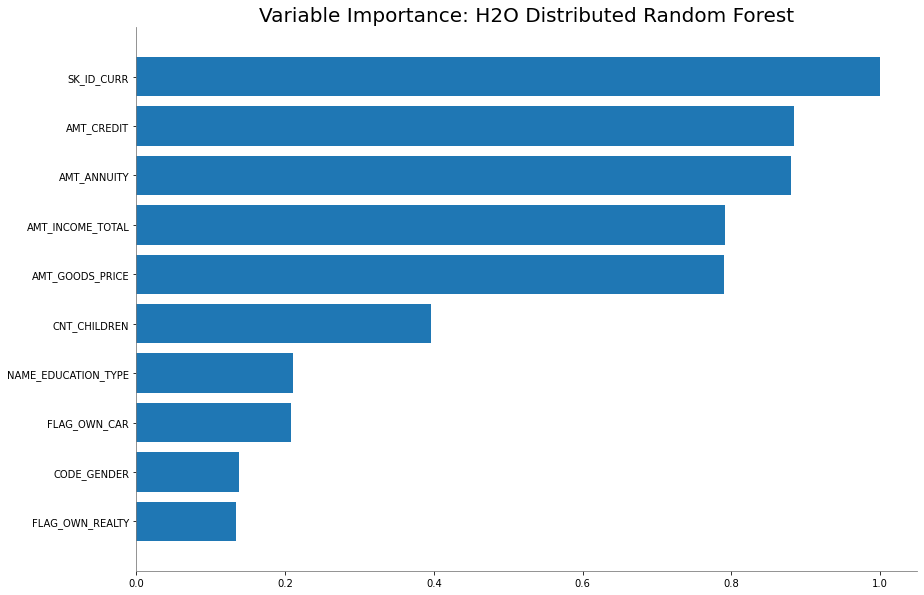

In [15]:
drf.varimp_plot(server=True)

From this, we can see there is no single feature that vastly stands above the rest.
However, it looks like the top five features have relatively more importance than the
rest , and there is a somewhat large drop in importance after the fifth feature (CODE_
GENDER).

> One interesting thing about tree-based feature importances is they
can change if we remove other features. Sometimes the changes
can be dramatic and features will move drastically in their ranking.
For example, try removing the topmost important feature and
examining the feature importances again.    

## Using SKLEARN Random Forest Feature Importances



c:\Users\INNO\Documents\Python Development\Practical Data Science\final_env\final_env\lib\site-packages\yellowbrick\base.py:246: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


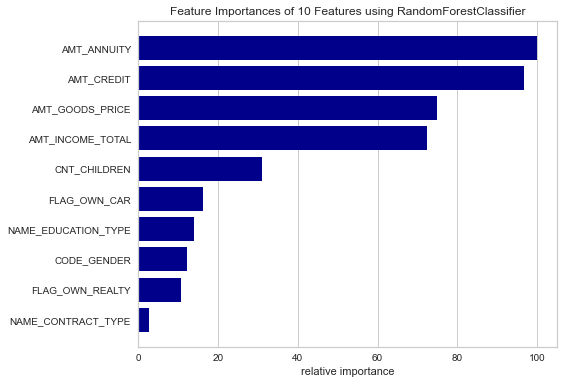

In [16]:
from yellowbrick.model_selection import feature_importances


_ = feature_importances(gs.best_estimator_,
                        x_train, 
                        y_train,
                        colors = ['darkblue'] * features.shape[0]
                        )

We can see there are some differences in the feature importances between `H2O` and
`sklearn`. Remember that a big difference was that we included the missing values
and categorical columns (such as NAME_EDUCATION_TYPE) as-is with the H2O random forest, while we pre-processed our data for sklearn to convert everything to numeric values and removed all missing values.


Random forests are a good model to try and often work well. However, another
class of tree-based models was created that improves upon random forests and often outperforms them: boosted models.

## Boosted Trees: AdaBoost, xgbOOST, LightGBM, and CatBoost

Boosted machine learning models were first introduced around 1989 and have been shown to perform well. Some of the more common boosting algorithms you will see are AdaBoost, gradient boosting, XGBoost, LightGBM, and CatBoost.


XGBoost has been used to win several machine learning competitions (for example, on Kaggle), and was initially released in 2014. LightGBM was developed shortly after by Microsoft and released in 2016, while CatBoost was released in 2017. (For a more detailed history of boosting, see this paper: https://cseweb.ucsd.edu/~yfreund/papers/IntroToBoosting.pdf.) 

These boosting algorithms have slightly different algorithms and implementations, and when trying models on a dataset, it doesn't hurt to try as many of them as you can. An easy way to do this is with the PyCaret
package

### AdaBoost

With AdaBoost, we can choose what our weak learner is, but usually it is a 1-split
decision tree (called a "stump"). The `sklearn` package has classification and
regression versions of AdaBoost, and we can use the classifier with our loan payment
dataset:

In [139]:
from sklearn.ensemble import AdaBoostClassifier


adaboost = AdaBoostClassifier(n_estimators = 100, random_state = 42, learning_rate = 0.5)


adaboost.fit(x_train, y_train)

print(adaboost.score(x_train, y_train))
print(adaboost.score(x_test, y_test))

0.9180765805877115
0.9146666666666666


Again, this works the same as all other sklearn ML algorithms – create the classifier,
fit to the data, then score and make predictions. The two hyperparameters for
AdaBoost in sklearn are the number of weak learners and the learning rate.


These two interact – the lower the learning rate, the more estimators we will need
to arrive at comparable performance. We can also change the base learner from a
decision tree stump to another ML algorithm with the base_estimator argument.
Our train and test scores here are about the same as the no information rate at 0.919.


We can optimize the `hyperparameters` with the grid search or Bayesian search
methods. But we can also use the pycaret package to easily search some hyperparameters with cross-validation.

We will need to first set up our data (the datatypes should be checked,
and confirmed by pressing Enter):

In [162]:
from pycaret.classification import setup, create_model, tune_model

classification = setup(data=final_df, target = "TARGET", )

,Description,Value
0,session_id,1980
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(307217, 11)"
5,Missing Values,0
6,Numeric Features,4
7,Categorical Features,6
8,Ordinal Features,0
9,High Cardinality Features,0


In [163]:
ada_boost = create_model("ada", fold = 3)

tuned_ada_boost, grid_search = tune_model(ada_boost, fold = 3, return_tuner = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9194,0.6272,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9194,0.6165,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9194,0.6156,0.0000,0.0000,0.0000,0.0000,0.0000
Mean,0.9194,0.6198,0.0000,0.0000,0.0000,0.0000,0.0000
SD,0.0000,0.0053,0.0000,0.0000,0.0000,0.0000,0.0000


We set the fold argument to 3 to use 3-fold cross-validation – the default is 10-
fold, and this algorithm already takes a long time to fit. In fact, you may want to
sample down the data to test this if it takes too long. This searches a default spread
of hyperparameters and we can access the hyperparameters and scores from the
gridsearch variable that was returned because we set return_tuner=True.


The results from the hyperparameter search (if we use the default sklearn grid
search) can be found from gridsearch.cv_results_['params'] and gridsearch.
cv_results_['mean_test_score'] (for example, you might use zip() to combine and
print these out).


Another way to use AdaBoost is directly from sklearn with the AdaBoostClassifier
and AdaBoostRegressor classes, along with using a tuner like the sklearn grid search
or another package for searching hyperparameters.




AdaBoost can work well for some problems but has been shown to sometimes
not work well when the data has too much noise or a specific type of noise.
Other boosting algorithms, such as the ones we will cover next, often outperform
AdaBoost.

### XGBoost

XGBoost stands for "extreme gradient boosting." It makes several improvements
upon plain gradient boosting, such as using Newton boosting. Instead of finding
the ideal multiplier to scale each weak learner by (which is like a step length in our
gradient descent), XGBoost solves the direction and step length in one equation. By
contrast, gradient boosting uses something called a line search to find the optimum
multiplier (step length) for each weak learner. This means XGBoost can be faster than
plain gradient boosting. It also is implemented in several coding languages, meaning
it can be deployed in a number of situations. Additionally, it can be used with big
data in a few different ways, such as Dask, H2O, Spark, and AWS SageMaker.

### XGBoost with PyCaret

Again, we can use xgboost easily through pycaret, which, by default, searches the
following hyperparameter space:


- learning_rate: 0.0000001 to 0.5
- n_estmators: 10-300 in steps of 10
- subsample: 0.2 to 1
- max_depth: 1 to 11 in steps of 1
- colsample_bytree: 0.5 to 1
- min_child_weight: 1 to 4 in steps of 1
- reg_alpha: 0.0000001 to 10
- reg_lambda: 0.0000001 to 10
- scale_pos_weight: 0 to 50 in steps of 0.1

We can see XGBoost has many more hyperparameters than AdaBoost. This is done
using an sklearn grid search by default, so it can take a long time. To speed it
up, we can use another tuner, like Bayesian search, which searches the following
hyperparameter spaces by default in pycaret:

In [8]:
# tune_distributions = {
#                        "learning_rate": UniformDistribution(0.000001, 0.5, log=True),
#                        "n_estimators": IntUniformDistribution(10, 300),
#                        "subsample": UniformDistribution(0.2, 1),
#                        "max_depth": IntUniformDistribution(1, 11),
#                        "colsample_bytree": UniformDistribution(0.5, 1),
#                        "min_child_weight": IntUniformDistribution(1, 4),
#                        "reg_alpha": UniformDistribution(0.0000000001, 10, log=True),
#                        "reg_lambda": UniformDistribution(0.0000000001, 10, log=True),
#                        "scale_pos_weight": UniformDistribution(1, 50),
#}


We can see it's the same areas as the grid search. These hyperparameters represent
the following:

- learning_rate: the scaling factor that multiplies incremental trees in the
algorithm
- n_estmators: the number of trees in the algorithm
- subsample: the fraction of data sampled for each tree
- max_depth: the depth of each tree (number of splits)
- colsample_bytree: the fraction of features sampled for each tree
- min_child_weight: determines if a node should split or not based on the
purity of samples in the node
- reg_alpha: L1 regularization of weights for each leaf (each leaf of each tree
has a weight associated with it in the XGBoost implementation)
- reg_lambda: L2 regularization of weights for each leaf
- scale_pos_weight: This controls the balance of positive and negative values
for a binary classification problem

The pycaret search spaces are generally good, although some people use different
strategies for tuning XGBoost hyperparameters. Some strategies will fix the number
of trees and tune the learning rate, while others fix the learning rate and tune the
number of trees. Using xgboost with pycaret is the same as with AdaBoost, but we
will use the scikit-optimize Bayesian search here with 10 iterations (so it completes
faster than the grid search from sklearn):

In [164]:
import xgboost

xgb = create_model("xgboost", fold = 3)

best_xgb, tuner = tune_model(xgb,
                             fold = 3,  
                             search_library = "scikit-optimize",
                             return_tuner = True
                             )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9194,0.6137,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9194,0.5977,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9194,0.6074,0.0000,0.0000,0.0000,0.0000,0.0000
Mean,0.9194,0.6063,0.0000,0.0000,0.0000,0.0000,0.0000
SD,0.0000,0.0066,0.0000,0.0000,0.0000,0.0000,0.0000


> If you see an error similar to ValueError: Estimator xgboost not
available, you will need to install xgboost with conda or pip. A pip
install will include GPU support (for Window and Linux) as long
as you have installed CUDA first. An easy way to install CUDA is
with conda install -c anaconda cudatoolkit.

In [165]:
# Best results

best_xgb.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.6489901613145924,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.0012348552837614137,
 'max_delta_step': 0,
 'max_depth': 2,
 'min_child_weight': 3,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 18,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 1980,
 'reg_alpha': 6.172650040638662,
 'reg_lambda': 5.8265833278527836e-09,
 'scale_pos_weight': 2.103821536756728,
 'subsample': 0.8142597613411604,
 'tree_method': 'auto',
 'validate_parameters': 1,
 'verbosity': 0}

In [166]:
# Get CV results 

tuner.cv_results_['params']

[OrderedDict([('actual_estimator__colsample_bytree', 0.970136877041888),
              ('actual_estimator__learning_rate', 0.00039381361449212674),
              ('actual_estimator__max_depth', 3),
              ('actual_estimator__min_child_weight', 3),
              ('actual_estimator__n_estimators', 143),
              ('actual_estimator__reg_alpha', 1.5288412592503967e-08),
              ('actual_estimator__reg_lambda', 2.2709590343692762e-05),
              ('actual_estimator__scale_pos_weight', 49.91753331173587),
              ('actual_estimator__subsample', 0.4803734904548599)]),
 OrderedDict([('actual_estimator__colsample_bytree', 0.6240378601903266),
              ('actual_estimator__learning_rate', 3.386679586776302e-06),
              ('actual_estimator__max_depth', 5),
              ('actual_estimator__min_child_weight', 3),
              ('actual_estimator__n_estimators', 78),
              ('actual_estimator__reg_alpha', 4.72391609165053e-08),
              ('actual_esti

In [167]:
tuner.cv_results_['mean_test_score']

array([0.08439859, 0.09188053, 0.91936331, 0.08692822, 0.91936331,
       0.87533189, 0.70458635, 0.15639085, 0.09512165, 0.11420083])

As with random forests and other tree-based methods, we can get the feature
importances. With an xgboost model (assuming we are using the sklearn API for
xgboost as we are here), this can be retrieved from xgb_model.get_booster().get_
score() or best_xgb.feature_importances_, which gives us the feature importance
by weight.

### XGBoost with the xgboost package

We can also use the xgboost package directly to create and train a model. For this,
we first import the package with the alias xgb as is the convention in the xgboost
documentation:

In [143]:
import xgboost as xgb


# Next, convert data to a DMMatrix xgboost data type

dtrain = xgb.DMatrix(x_train, label = y_train)

dtest = xgb.DMatrix(x_test, label = y_test)


> We give the features as the first argument and the label as the second argument
(which we also provide with the keyword label here, although it's not required).
Now we can train the model:    

In [144]:
xgb_model = xgb.train(params={'objective': 'binary:logistic'}, dtrain=dtrain)



The first argument is the hyperparameters, set with the params keyword. The
only thing we must set here is the objective function, which is 'binary:logistic'
for binary classification (by default it's 'req:squarederror' for regression with
a squared error loss function). We can also set other hyperparameters if we wish.

In [145]:
from sklearn.metrics import accuracy_score


train_preds = xgb_model.predict(dtrain)

test_preds = xgb_model.predict(dtest)


print(accuracy_score(y_train, train_preds > 0.5))
print(accuracy_score(y_test, test_preds > 0.5))

0.9180765805877115
0.912


The predictions from the model are probability predictions, so we need to provide a
threshold from which to round predictions up to 1. In this case, we use a value of 0.5,
which is the default for other models. Notice that we also need to give a DMatrix as
our data for the predict function.

### The XGBoost scikit-learn API

The xgboost package also has an sklearn API which makes it easy to use xgboost
in the same way we do with scikit-learn models. This can make it easier to use with
sklearn pipelines and other tools that depend on a model behaving as others do in
sklearn. To use this API, we create our model like so:

In [146]:
xgb_model = xgb.XGBClassifier()

fit_model = xgb_model.fit(x_train, y_train)

This allows us to provide pandas DataFrames or other data structures besides
DMatrix datatypes to the fit function. Then we can evaluate the model in the same
way as other sklearn models:

In [147]:
fit_model.score(x_train, y_train)

0.9973285841495992

This computes the accuracy of the model. Of course, we can do something similar
for regression with xgb.XGBRegressor(). The xgboost documentation also lays out
more details on the use of the xgboost package, including the sklearn API methods
we touched on here. As with sklearn models, we also have predict and predict_
proba methods with our xgboost models in the sklearn API style, which can give
us predicted values and probabilities, respectively

### LightGBM

LightGBM is a newer algorithm that includes some improvements compared with
XGBoost, although it does not always outperform XGBoost in practice. It creates the
decision trees in the ensemble differently using novel techniques (described in the
original paper: https://papers.nips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf), which allows it to run faster and use less memory than
XGBoost. It also can handle missing values and categorical data natively. It was
created by Microsoft and is what Azure's ML GUI uses when a boosted decision
tree ML algorithm is chosen

> One note on LightGBM is that we should convert object
datatypes to category in pandas DataFrames if we wish to
use categorical features directly (for example, without one-hot
encoding them). We can efficiently do this like so:

In [169]:
#for col in final_df.select_dtypes(include = ["object"]):
#    final_df[col] = final_df[col].astype("category")



light_gbm = create_model('lightgbm', fold=3)

best_lgbm, tuner = tune_model(light_gbm,
                            fold=2,
                            search_library='scikit-optimize',
                            return_tuner=True)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9194,0.6360,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9194,0.6348,0.0000,0.0000,0.0000,0.0000,0.0000
Mean,0.9194,0.6354,0.0000,0.0000,0.0000,0.0000,0.0000
SD,0.0000,0.0006,0.0000,0.0000,0.0000,0.0000,0.0000


In [148]:
import lightgbm as lgb

train_data = lgb.Dataset(x_train, label = y_train)
test_data = lgb.Dataset(x_test, label = y_test)


parameters = {
    "objective": "binary",
    "metric": "auc",
    "is_unbalance": "true",
    "boosting": "gbdt",
    "num_leaves": 63,
    "feature_fraction": 0.5,
    "bagging_fraction": 0.5,
    "bagging_freq": 20,
    "learning_rate": 0.05,
    "verbose": -1
}


model_lgbm = lightgbm.train(parameters,
                            train_data,
                            valid_sets = test_data,
                            num_boost_round=5000,
                            early_stopping_rounds=50)

[1]	valid_0's auc: 0.518814
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.514441
[3]	valid_0's auc: 0.537764
[4]	valid_0's auc: 0.540725
[5]	valid_0's auc: 0.553298
[6]	valid_0's auc: 0.547467
[7]	valid_0's auc: 0.556715
[8]	valid_0's auc: 0.548014
[9]	valid_0's auc: 0.55102
[10]	valid_0's auc: 0.551066
[11]	valid_0's auc: 0.557261
[12]	valid_0's auc: 0.555075
[13]	valid_0's auc: 0.554756
[14]	valid_0's auc: 0.550109
[15]	valid_0's auc: 0.555302
[16]	valid_0's auc: 0.552205
[17]	valid_0's auc: 0.548469
[18]	valid_0's auc: 0.556487
[19]	valid_0's auc: 0.559311
[20]	valid_0's auc: 0.561316
[21]	valid_0's auc: 0.565415
[22]	valid_0's auc: 0.568058
[23]	valid_0's auc: 0.574435
[24]	valid_0's auc: 0.575893
[25]	valid_0's auc: 0.580995
[26]	valid_0's auc: 0.587919
[27]	valid_0's auc: 0.590288
[28]	valid_0's auc: 0.589832
[29]	valid_0's auc: 0.592748
[30]	valid_0's auc: 0.590379
[31]	valid_0's auc: 0.589923
[32]	valid_0's auc: 0.590015
[33]	valid_0's auc: 0

In [149]:
from sklearn.metrics import roc_auc_score

y_train_pred = model_lgbm.predict(x_train)
y_test_pred = model_lgbm.predict(x_test)


print(f"AUC Train: {roc_auc_score(y_train, y_train_pred):.4f}")
print(f"AUC Train: {roc_auc_score(y_test, y_test_pred):.4f}")

AUC Train: 0.8185
AUC Train: 0.5927


## CatBoost

One last boosting algorithm we'll cover is CatBoost, which is the newest of the
boosting algorithms discussed here. CatBoost is similar to XGBoost, using boosted
decision trees, but has some advantages:

- Ostensibly less hyperparameter tuning than XGBoost (simpler to tune)
- Can handle missing data and categorical values natively
- Trains quickly, similar to LightGBM


There is a catboost package in Python where we can use the package directly, but
we will first show usage through pycaret. If using the base catboost package, we
can also plot some model metrics and show them as the model trains (such as the
accuracy as it fits more trees).

In [171]:
catboost_model = create_model('catboost', fold=3)

best_cb, tuner = tune_model(catboost_model,
                            fold=2,
                            search_library='scikit-optimize',
                            return_tuner=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9194,0.6379,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9194,0.6358,0.0000,0.0000,0.0000,0.0000,0.0000
Mean,0.9194,0.6369,0.0000,0.0000,0.0000,0.0000,0.0000
SD,0.0000,0.0011,0.0000,0.0000,0.0000,0.0000,0.0000


The results from the tuning with an accuracy of 0.9194 versus no information rate of 0.9193 – this is not really a significant result, but it is interesting that CatBoost shows a hint of performing better than XGBoost and LightGBM here.

### Using CatBoost Natively



In [173]:
from catboost import CatBoostClassifier, Pool


cb_model = CatBoostClassifier()

catboost_train_data = Pool(x_train, label = y_train)

cb_model.fit(catboost_train_data, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.010825
0:	learn: 0.6821363	total: 3.94ms	remaining: 3.94s
1:	learn: 0.6712810	total: 6.31ms	remaining: 3.15s
2:	learn: 0.6607985	total: 9.74ms	remaining: 3.24s
3:	learn: 0.6503155	total: 12.2ms	remaining: 3.03s
4:	learn: 0.6400864	total: 15.3ms	remaining: 3.04s
5:	learn: 0.6298525	total: 18.4ms	remaining: 3.05s
6:	learn: 0.6204033	total: 21.5ms	remaining: 3.05s
7:	learn: 0.6114720	total: 24.4ms	remaining: 3.02s
8:	learn: 0.6023788	total: 26.8ms	remaining: 2.95s
9:	learn: 0.5938344	total: 28.9ms	remaining: 2.87s
10:	learn: 0.5856042	total: 30ms	remaining: 2.7s
11:	learn: 0.5775859	total: 33.7ms	remaining: 2.77s
12:	learn: 0.5696630	total: 35.9ms	remaining: 2.73s
13:	learn: 0.5620026	total: 43.6ms	remaining: 3.07s
14:	learn: 0.5543107	total: 50ms	remaining: 3.28s
15:	learn: 0.5471496	total: 53.4ms	remaining: 3.28s
16:	learn: 0.5396157	total: 56.6ms	remaining: 3.27s
17:	learn: 0.5324515	total: 63.9ms	remaining: 3.48s
18:	learn: 0.5254633	total: 70.5ms	remaining: 3.6

This outputs in real time the value of the metrics (by default, the loss function), the
total runtime, and time remaining. We can also visualize the metrics by providing
the argument plot=True to fit. Once completed, we can use other methods, such as
score, to get the accuracy: cb_model.score(catboost_train_data). We can also use
predict and predict_proba on new data with only features (no targets) like this:

In [174]:
catboost_test_data = Pool(x_test)

cb_model.predict(catboost_test_data)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

First, we create a dataset with the catboost Pool class, giving it only our features.
Then we simply use the predict method of our model on this data. There are many
other methods of catboost models described in the documentation.

## Using early stopping with boosting algorithms

When training the XGBoost, LightGBM, and CatBoost models, we can use a practice
called `early stopping` to prevent overfitting. This method is used when fitting
the model. We provide a training dataset and a validation set, and our metrics
are calculated on both datasets after each new tree is added to the model. If the
validation metric does not improve for a specified number of rounds (new trees
added), then the model training is stopped and the model iteration with the best
validation score is selected.

In [175]:
import catboost


new_cb = catboost.CatBoostClassifier(**best_cb.get_params())

new_cb.set_params(n_estimators=1000)

new_cb.fit(X=x_train,
            y=y_train,
            eval_set=(x_test, y_test),
            early_stopping_rounds=10,
            plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [176]:
new_cb.tree_count_

93

We are using our parameters from the best CatBoost model we found from model
tuning using pycaret, and the ** before the dictionary is dictionary unpacking.
This expands each dictionary item as an argument to the function or class, so if our
dictionary has an element best_cb.get_params()['n_estimators'] = 100, (or {'n_
estimators': 10}) then this would be the same as providing n_estimators=100 in
the CatBoostClassifier class. We then increase the number of estimators to a large
value so we can see early stopping work. Finally, we fit the model to our train set
and use the test set as the evaluation set. The plot=True argument shows the train
and validation scores as it trains. We can see it stops early by examining the number
of trees with new_cb.tree_count_, which returns 93.


Although early stopping can be used to prevent overfitting, we can also use things
like regularization (l2_leaf_reg for catboost, for example) and cross-validation to
prevent and check for overfitting. In fact, using tune_model from pycaret provides a
way to avoid overfitting, since we are optimizing the hyperparameters by using the
metric score on a validation set.